In [1]:
from __future__ import annotations
import argparse
from typing import Iterable, Tuple

import numpy as np
import matplotlib.pyplot as plt

from sigma_competition_process import (
    SigmaCompetition,
    build_core,
    step_alloc_once,
)


In [5]:

# ---------------------------- Single run ----------------------------
def run_single(core=None, seed: int | None = None) -> None:
    """Time-course with a transient increase in alternative sigma (σAlt)."""
    if seed is not None:
        np.random.seed(seed)

    core = core or build_core()
    defaults = SigmaCompetition(core=core).config

    T_end, dt = 60.0, 0.5
    times = np.arange(0.0, T_end + dt, dt)

    sigma_alt_baseline = float(defaults['sigmaS_total'])
    sigma_alt_pulse = sigma_alt_baseline * 2.0

    E_free, E70, EAlt, J70, JAlt = [], [], [], [], []
    for t in times:
        cfg = dict(defaults)
        cfg['sigmaS_total'] = sigma_alt_pulse if (20.0 < t < 40.0) else sigma_alt_baseline
        out = step_alloc_once(core, cfg)
        E_free.append(out['E_free'])
        E70.append(out['E_sigma70'])
        EAlt.append(out['E_sigmaS'])
        J70.append(out['J_sigma70'])
        JAlt.append(out['J_sigmaS'])

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax = axes[0]
    ax.plot(times, E_free, label='E_free', lw=1.5)
    ax.plot(times, E70, label='E·σ70', lw=1.5)
    ax.plot(times, EAlt, label='E·σAlt', lw=1.5)
    ax.axvspan(20, 40, color='orange', alpha=0.15, label='σAlt increase')
    ax.set_ylabel('RNAP holoenzyme (a.u.)')
    ax.set_title('RNAP allocation')
    yl = _padded_ylim(E_free + E70 + EAlt)
    if yl:
        ax.set_ylim(*yl)
    ax.legend()

    ax = axes[1]
    ax.plot(times, J70, label='J_σ70', lw=1.5)
    ax.plot(times, JAlt, label='J_σAlt', lw=1.5)
    ax.axvspan(20, 40, color='orange', alpha=0.15)
    ax.set_xlabel('time')
    ax.set_ylabel('rate (a.u.)')
    ax.set_title('Transcription rates')
    yl = _padded_ylim(J70 + JAlt)
    if yl:
        ax.set_ylim(*yl)
    ax.legend()

    plt.tight_layout()
    plt.show()




In [8]:
# ---------------------------- Figure A, B, C ----------------------------
def regenerate_figure(core=None, seed: int | None = None) -> None:
    """
    Reproduce three panels analogous to Mauri & Klumpp (2014):
      A) E·σ70 and E·σAlt vs σAlt with σ70 fixed
      B) Binding curves (other sigma = 0), normalized by max(E·σ)
      C) Fraction E·σ70 / (E·σ70 + E·σAlt) vs total σ at equimolar σ70 = σAlt,
         using Kd_alt < Kd70 to match the observed trend.
    """
    if seed is not None:
        np.random.seed(seed)

    core = core or build_core()
    defaults = SigmaCompetition(core=core).config

    # Panel A: σAlt sweep, σ70 fixed
    sigma70_fixed = float(defaults['sigma70_total'])
    sigma_alt_range = np.linspace(0.0, 20000.0, 200)
    E70_A, EAlt_A = [], []
    for s_alt in sigma_alt_range:
        cfg = dict(defaults)
        cfg['sigmaS_total'] = float(s_alt)
        cfg['sigma70_total'] = sigma70_fixed
        out = step_alloc_once(core, cfg)
        E70_A.append(out['E_sigma70'])
        EAlt_A.append(out['E_sigmaS'])

    # Panel B: binding curves (other sigma = 0) normalized
    s70_range = np.linspace(0.0, 20000.0, 120)
    sAlt_range = np.linspace(0.0, 20000.0, 120)
    E70_curve, EAlt_curve = [], []
    for s70 in s70_range:
        cfg = dict(defaults)
        cfg['sigmaS_total'] = 0.0
        cfg['sigma70_total'] = float(s70)
        E70_curve.append(step_alloc_once(core, cfg)['E_sigma70'])
    for s_alt in sAlt_range:
        cfg = dict(defaults)
        cfg['sigma70_total'] = 0.0
        cfg['sigmaS_total'] = float(s_alt)
        EAlt_curve.append(step_alloc_once(core, cfg)['E_sigmaS'])
    E70_max = max(E70_curve) or 1.0
    EAlt_max = max(EAlt_curve) or 1.0
    E70_norm = [e / E70_max for e in E70_curve]
    EAlt_norm = [e / EAlt_max for e in EAlt_curve]

    # Panel C: equimolar σ70=σAlt; set alt tighter than σ70 to match the trend
    Kd_sigma70_C = 0.8   # μM
    Kd_sigmaAlt_C = 0.4  # μM
    RNAP_total_uM = 1.0

    s_equal_uM = np.linspace(0.0, 2.0, 60)  # each sigma; total 0..4 μM
    frac_70, x_total_uM = [], []
    for s in s_equal_uM:
        cfg = dict(defaults)
        cfg['RNAP_total'] = RNAP_total_uM
        cfg['sigma70_total'] = float(s)
        cfg['sigmaS_total'] = float(s)
        cfg['Kd_sigma70'] = Kd_sigma70_C
        cfg['Kd_sigmaS'] = Kd_sigmaAlt_C
        out = step_alloc_once(core, cfg)
        denom = out['E_sigma70'] + out['E_sigmaS']
        frac_70.append((out['E_sigma70'] / (denom + 1e-12)) if denom > 0 else 0.0)
        x_total_uM.append(2.0 * float(s))
    # Plot
    fig = plt.figure(figsize=(14, 4.8))

    # A
    axA = fig.add_subplot(1, 3, 1)
    axA.plot(sigma_alt_range, E70_A, label='E·σ70', lw=1.8, color='tab:blue')
    axA.plot(sigma_alt_range, EAlt_A, label='E·σAlt', lw=1.8, color='tab:green')
    axA.set_xlabel('σAlt count (a.u.)')
    axA.set_ylabel('RNAP holoenzyme (a.u.)')
    axA.set_title('A) Holoenzyme vs σAlt (σ70 fixed)')
    yl = _padded_ylim(E70_A + EAlt_A)
    if yl:
        axA.set_ylim(*yl)
    axA.legend()

    # B
    axB_top = fig.add_subplot(2, 6, 3)
    axB_top.plot(s70_range, E70_norm, lw=1.8, color='tab:blue')
    axB_top.set_title('B) E·σ70 / max (σAlt=0)')
    axB_top.set_xlabel('σ70')
    axB_top.set_ylabel('normalized')

    axB_bot = fig.add_subplot(2, 6, 9)
    axB_bot.plot(sAlt_range, EAlt_norm, lw=1.8, color='tab:green')
    axB_bot.set_title('E·σAlt / max (σ70=0)')
    axB_bot.set_xlabel('σAlt')
    axB_bot.set_ylabel('normalized')

    # C
    axC = fig.add_subplot(1, 3, 3)
    axC.plot(x_total_uM, [1.0 - f for f in frac_70], label='E·σAlt fraction (Model)', lw=1.8, color='tab:green')
    axC.plot(x_total_uM, frac_70, label='E·σ70 fraction (Model)', lw=1.8, color='tab:blue')
    axC.set_xlabel('Total sigma concentration [σ70]+[σAlt] (μM)')
    axC.set_ylabel('Fraction of bound RNAP')
    axC.set_title('C) Fraction (σ70 = σAlt)')
    axC.set_ylim(-0.02, 1.02)
    axC.legend()

    plt.tight_layout()
    plt.show()



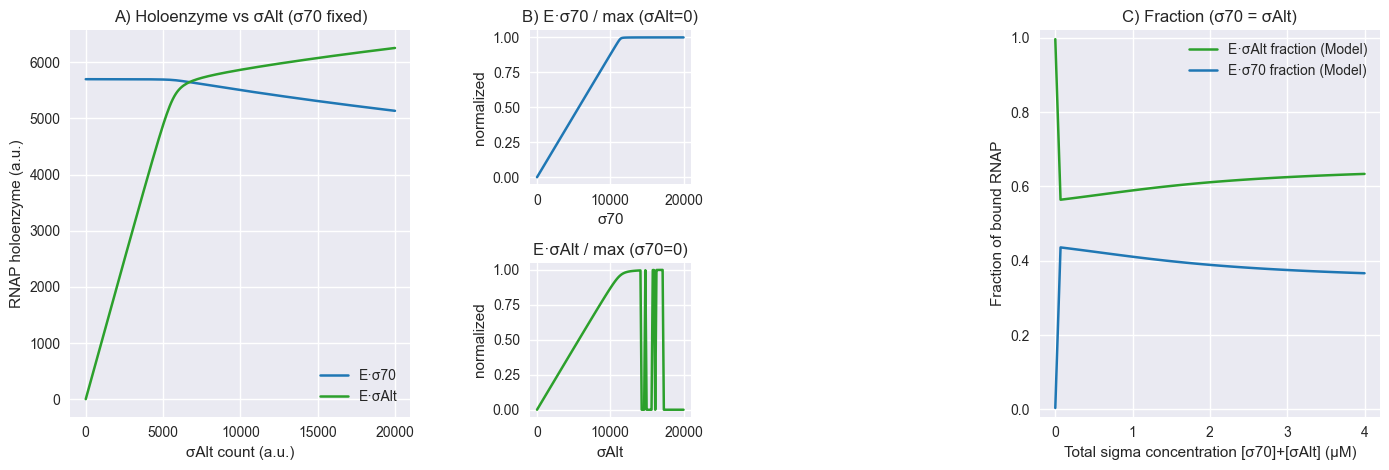

In [10]:
# ---------------------------- CLI ----------------------------
def parse_args(argv: list[str] | None = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Sigma-factor competition using process_bigraph Composite")
    p.add_argument('--mode', choices=['single', 'fig', 'client'], default='fig',
                   help="single: time-course; fig: three panels; client: alias for fig")
    p.add_argument('--seed', type=int, default=None, help="Random seed for reproducibility")
    p.add_argument('--style', type=str, default='seaborn-v0_8',
                   help="Matplotlib style (default: seaborn-v0_8)")
    ns, _unknown = p.parse_known_args(argv)
    if ns.mode == 'client':
        ns.mode = 'fig'
    return ns


def main(argv: list[str] | None = None) -> None:
    args = parse_args(argv)
    set_style(args.style)
    core = build_core()

    if args.mode == 'single':
        run_single(core=core, seed=args.seed)
    else:
        regenerate_figure(core=core, seed=args.seed)


if __name__ == "__main__":
    main()